In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
! pip install tensorboardX
! pip install pytorch-ignite
% cd /content/drive/My Drive/SSDS Research/GQN_Files/GQN-lite-master/gqn
import torch
from tqdm import tqdm
from gqn import GenerativeQueryNetwork, partition, Annealer
import torch
import torch.nn as nn
import random
from CircularOrbit import CircularOrbit
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import OrderedDict
def deterministic_partition(images, viewpoints, indices):
    """
    Partition batch into context and query sets.
    :param images
    :param viewpoints
    :return: context images, context viewpoint, query image, query viewpoint
    """
    # Maximum number of context points to use
    _, b, m, *x_dims = images.shape
    _, b, m, *v_dims = viewpoints.shape

    # "Squeeze" the batch dimension
    images = images.view((-1, m, *x_dims))
    viewpoints = viewpoints.view((-1, m, *v_dims))

    # Partition into context and query sets
    context_idx, query_idx = indices[:-1], indices[-1]

    x, v = images[:, context_idx], viewpoints[:, context_idx]
    x_q, v_q = images[:, query_idx], viewpoints[:, query_idx]

    return x, v, x_q, v_q

/content/drive/My Drive/SSDS Research/GQN_Files/GQN-lite-master/gqn


In [25]:
dataset = CircularOrbit("/content/drive/My Drive/SSDS Research/circular_orbit_dataset_2/", fraction=1) ## <= Choose your data location
loader = DataLoader(dataset, batch_size=1, shuffle=True)

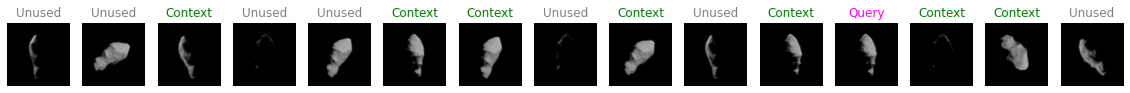

In [26]:
# Pick a scene to visualise
scene_id = 0

# Load data
x, v = next(iter(loader))
x_, v_ = x.squeeze(0), v.squeeze(0)

# Sample a set of views
n_context = 7 + 1
indices = random.sample([i for i in range(v_.size(1))], n_context)

# Seperate into context and query sets
x_c, v_c, x_q, v_q = deterministic_partition(x, v, indices)

# Visualise context and query images
f, axarr = plt.subplots(1, 15, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    # Move channel dimension to end
    ax.imshow(x_[scene_id][i].permute(1, 2, 0))
    
    if i == indices[-1]:
        ax.set_title("Query", color="magenta")
    elif i in indices[:-1]:
        ax.set_title("Context", color="green")
    else:
        ax.set_title("Unused", color="grey")
    
    ax.axis("off")

In [27]:
import os
import numpy as np
import matplotlib.animation as animation
checkpoint_dir = os.listdir('./pretrained/Circ_Orbit')
#checkpoint_dir = np.sort(checkpoint_dir)
list(checkpoint_dir), len(checkpoint_dir)

(['checkpoint_checkpoint_175.pt',
  'checkpoint_checkpoint_350.pt',
  'checkpoint_checkpoint_525.pt',
  'checkpoint_checkpoint_700.pt',
  'checkpoint_checkpoint_875.pt',
  'checkpoint_checkpoint_1050.pt',
  'checkpoint_checkpoint_1225.pt',
  'checkpoint_checkpoint_1400.pt',
  'checkpoint_checkpoint_1575.pt',
  'checkpoint_checkpoint_1750.pt',
  'checkpoint_checkpoint_1925.pt',
  'checkpoint_checkpoint_2100.pt',
  'checkpoint_checkpoint_2275.pt',
  'checkpoint_checkpoint_2450.pt',
  'checkpoint_checkpoint_2625.pt',
  'checkpoint_checkpoint_2800.pt',
  'checkpoint_checkpoint_2975.pt',
  'checkpoint_checkpoint_3150.pt',
  'checkpoint_checkpoint_3325.pt',
  'checkpoint_checkpoint_3500.pt',
  'checkpoint_checkpoint_3675.pt',
  'checkpoint_checkpoint_3850.pt',
  'checkpoint_checkpoint_4025.pt',
  'checkpoint_checkpoint_4200.pt',
  'checkpoint_checkpoint_4375.pt',
  'checkpoint_checkpoint_4550.pt',
  'checkpoint_checkpoint_4725.pt',
  'checkpoint_checkpoint_4900.pt',
  'checkpoint_checkpoint_



  0%|          | 0/144 [00:00<?, ?it/s]

  1%|          | 1/144 [00:03<07:19,  3.07s/it]

  1%|▏         | 2/144 [00:06<07:11,  3.04s/it]

  2%|▏         | 3/144 [00:09<07:05,  3.02s/it]

  3%|▎         | 4/144 [00:11<06:59,  3.00s/it]

  3%|▎         | 5/144 [00:16<08:16,  3.57s/it]

  4%|▍         | 6/144 [00:19<07:50,  3.41s/it]

  5%|▍         | 7/144 [00:24<08:20,  3.65s/it]

  6%|▌         | 8/144 [00:28<08:35,  3.79s/it]

  6%|▋         | 9/144 [00:32<08:43,  3.88s/it]

  7%|▋         | 10/144 [00:36<08:42,  3.90s/it]

  8%|▊         | 11/144 [00:39<08:15,  3.72s/it]

  8%|▊         | 12/144 [00:42<07:36,  3.46s/it]

  9%|▉         | 13/144 [00:46<07:51,  3.60s/it]

 10%|▉         | 14/144 [00:49<07:47,  3.60s/it]

 10%|█         | 15/144 [00:55<08:41,  4.05s/it]

 11%|█         | 16/144 [00:58<08:03,  3.78s/it]

 12%|█▏        | 17/144 [01:01<07:52,  3.72s/it]

 12%|█▎        | 18/144 [01:05<07:52,  3.75s/it]

 13%|█▎        | 19/144 [01:10<08:24,  4.04s/it]

 14%|█▍        |

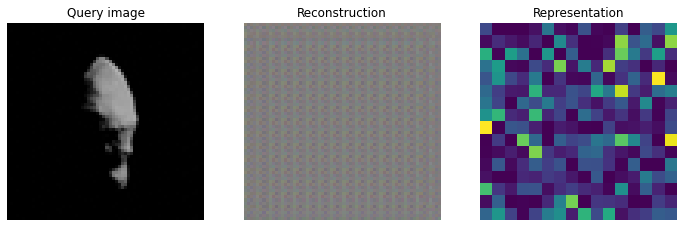

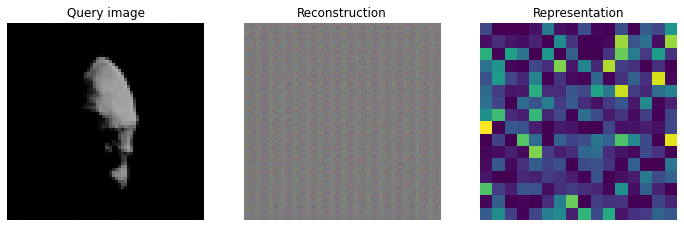

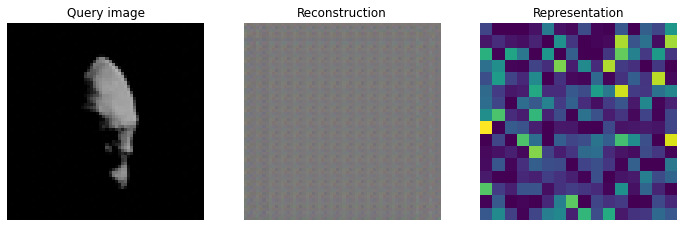

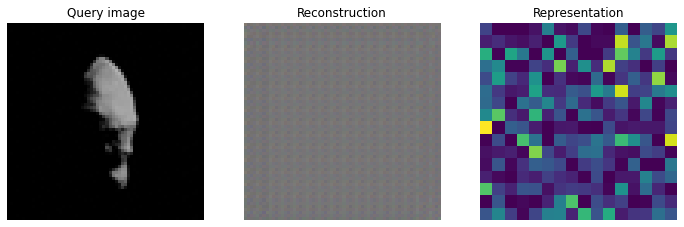

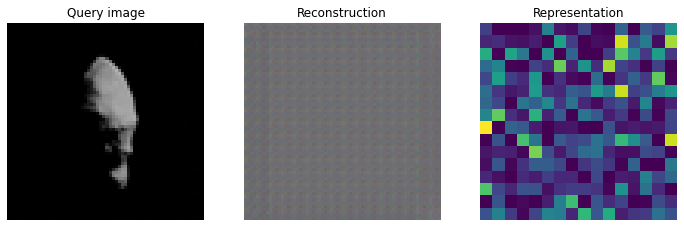

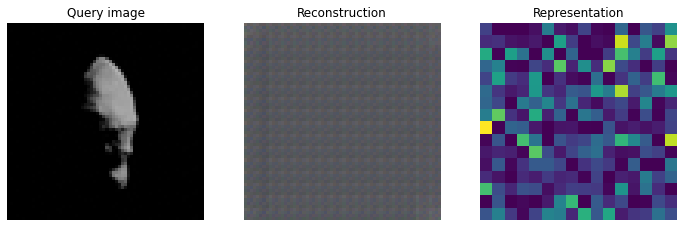

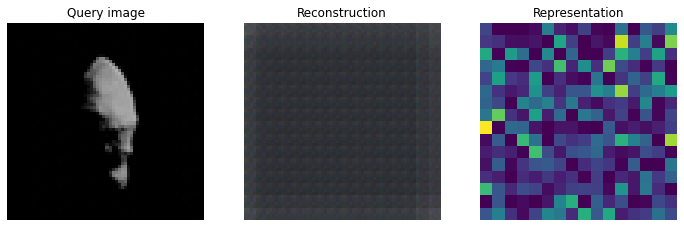

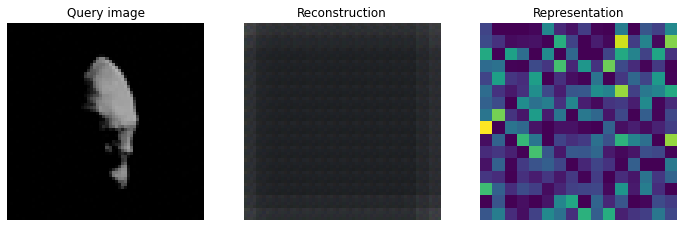

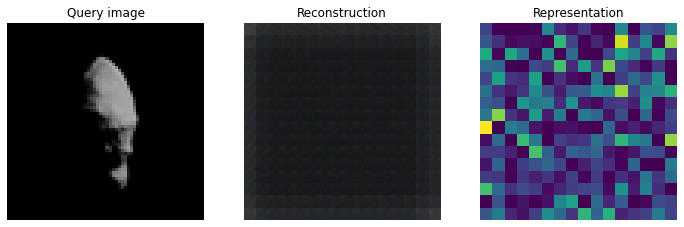

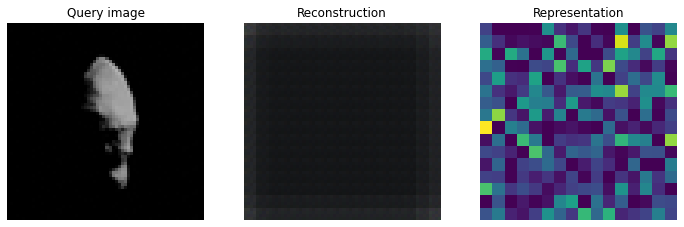

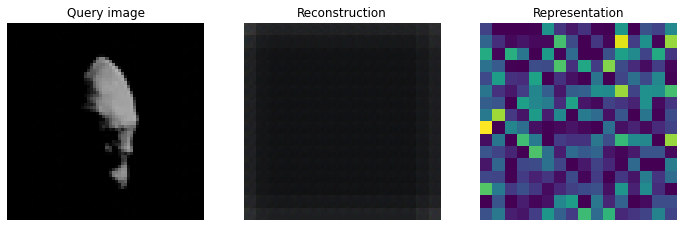

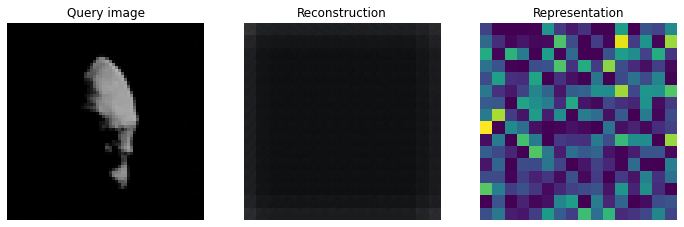

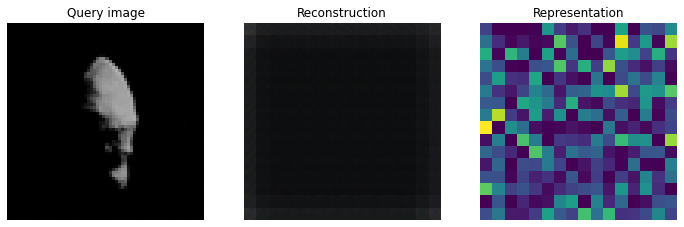

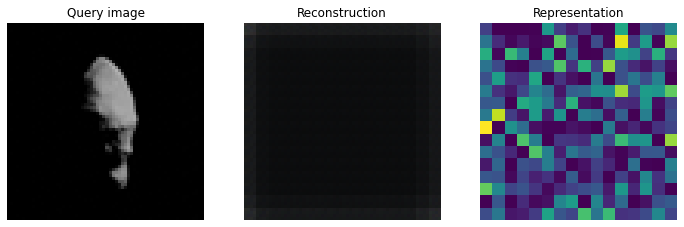

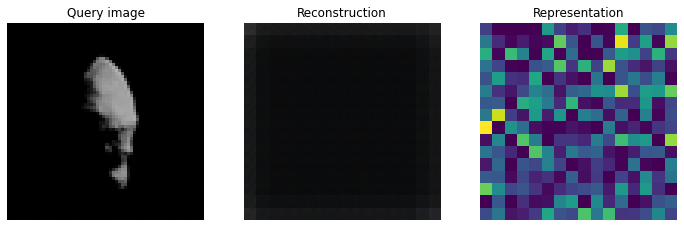

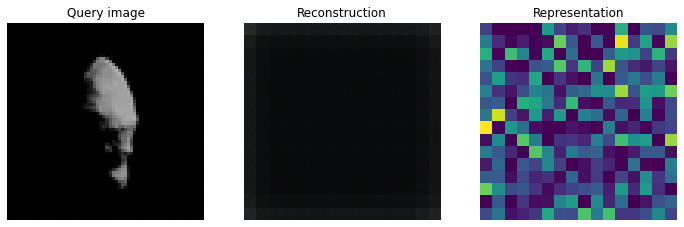

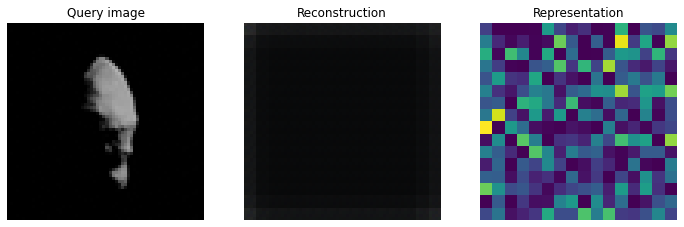

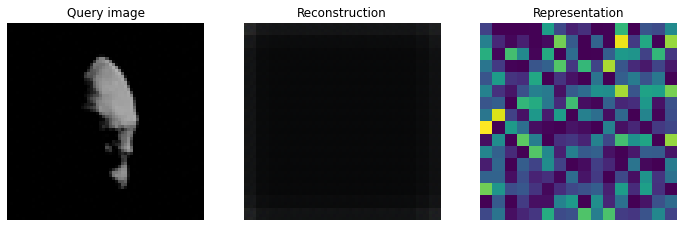

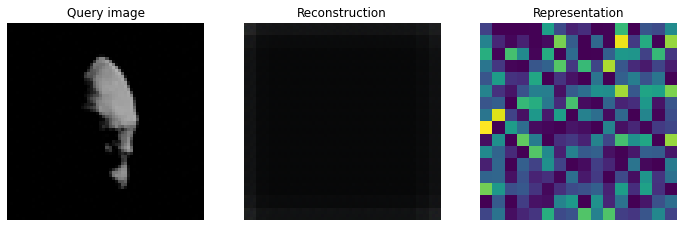

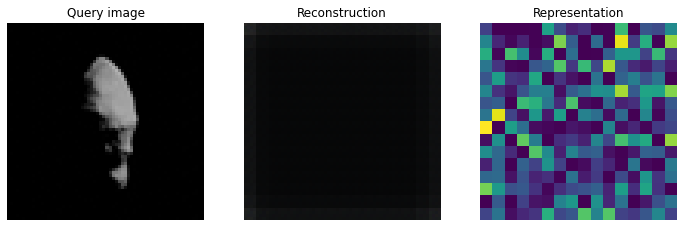

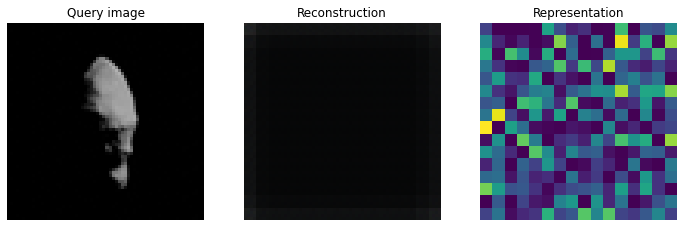

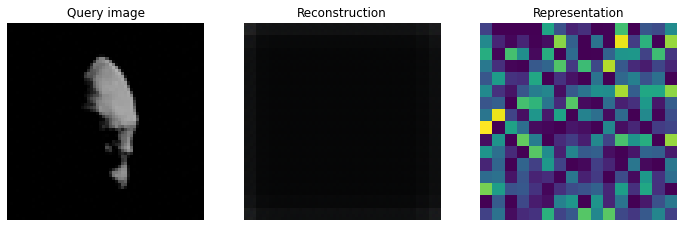

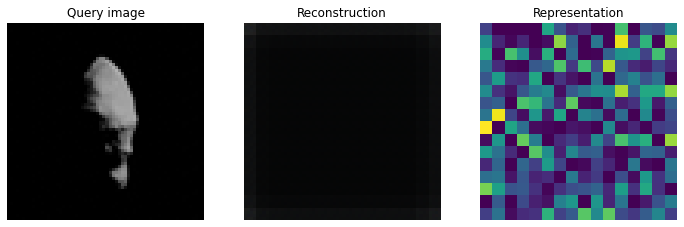

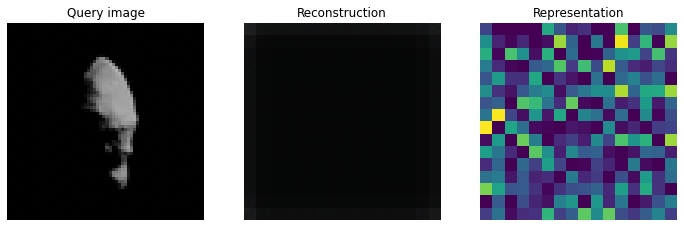

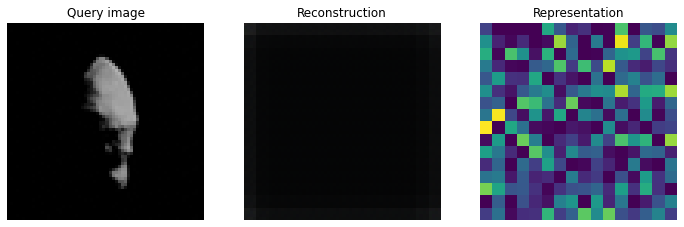

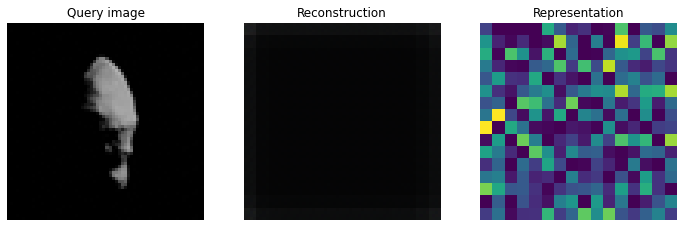

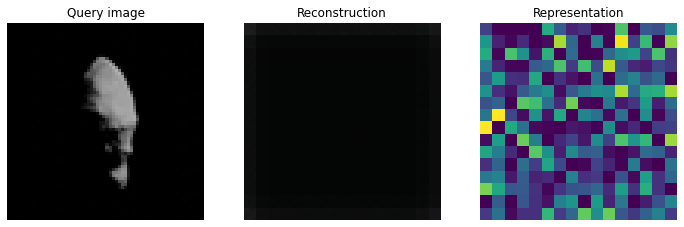

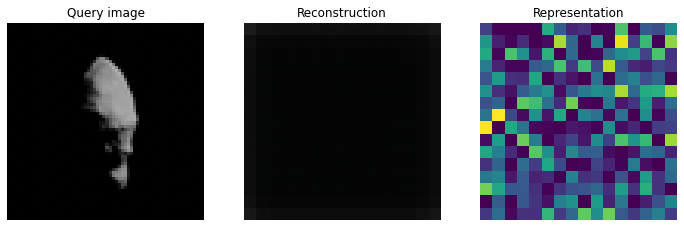

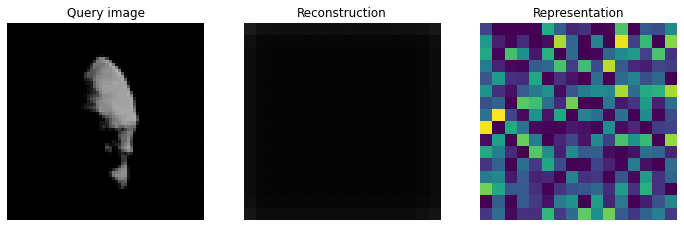

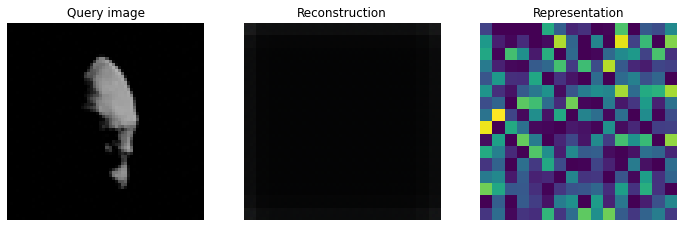

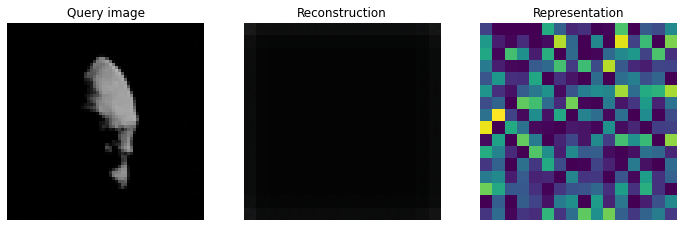

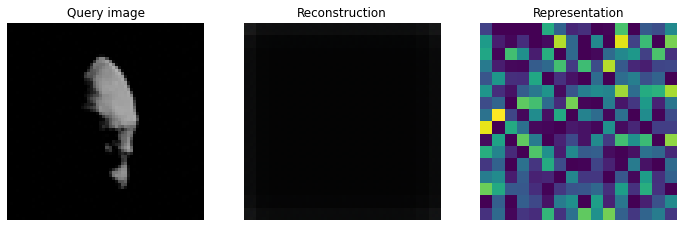

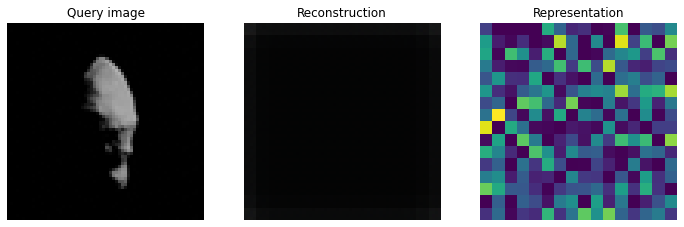

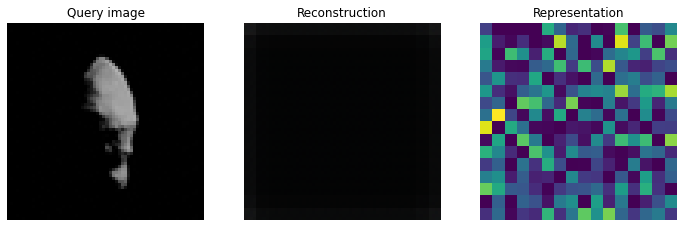

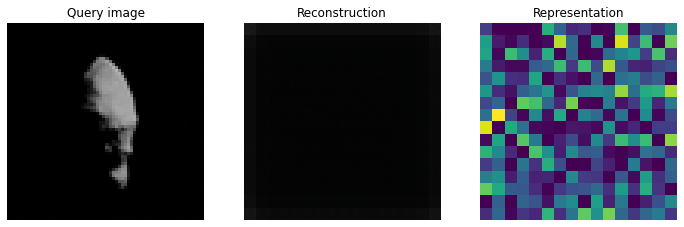

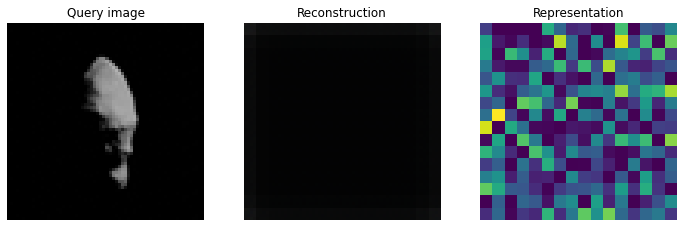

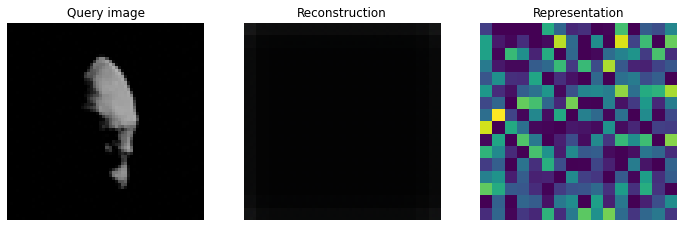

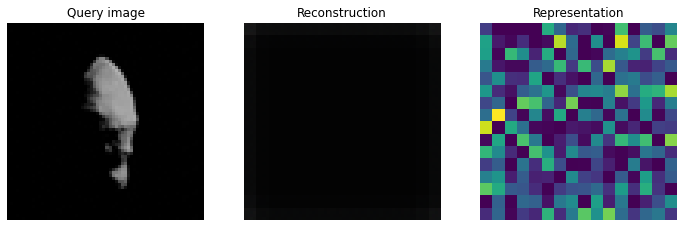

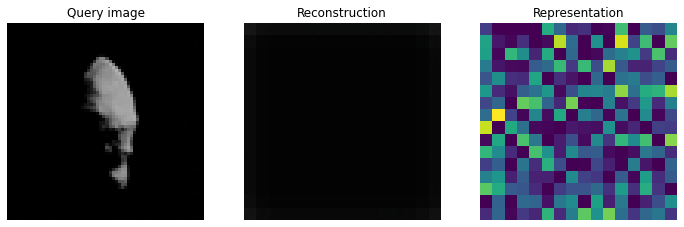

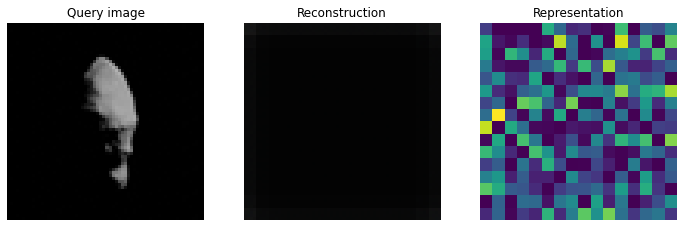

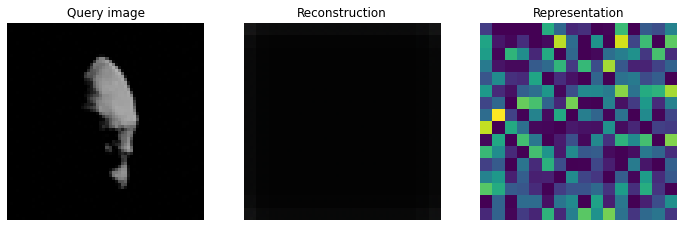

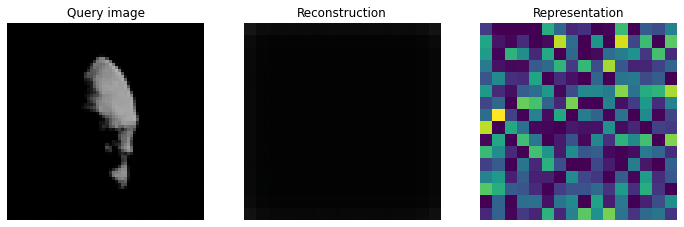

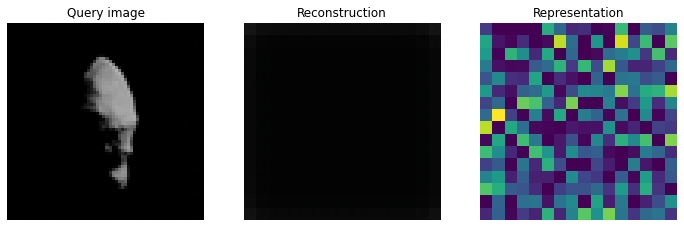

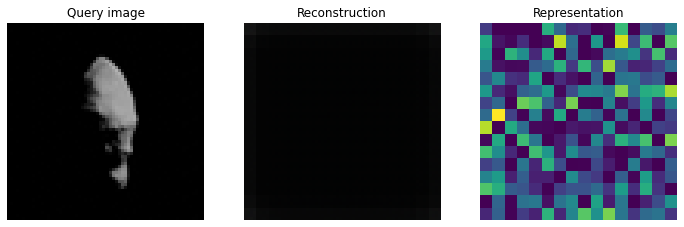

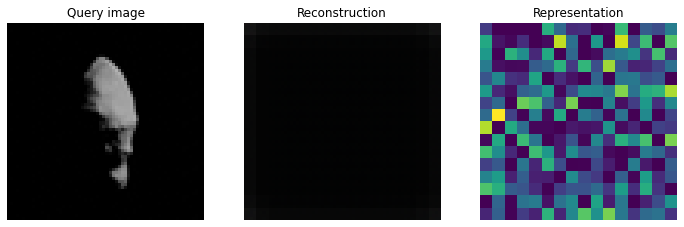

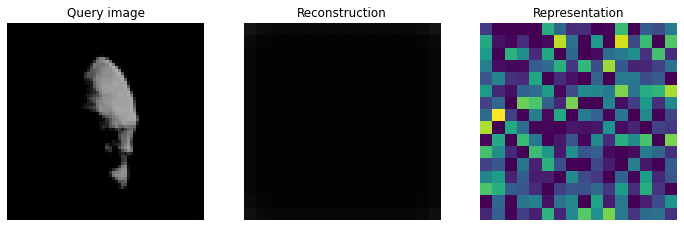

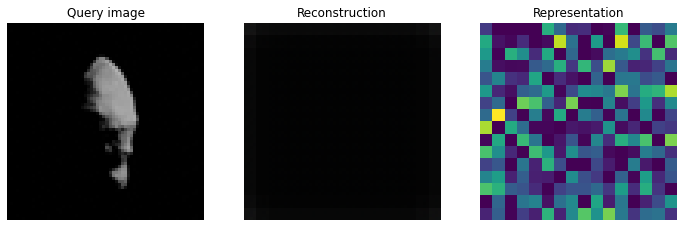

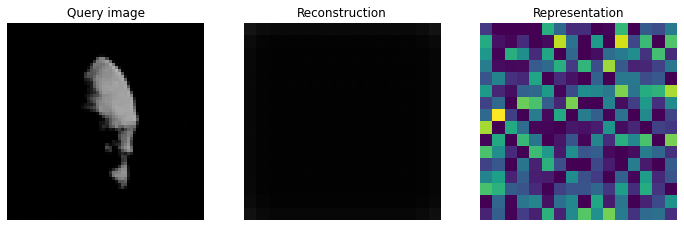

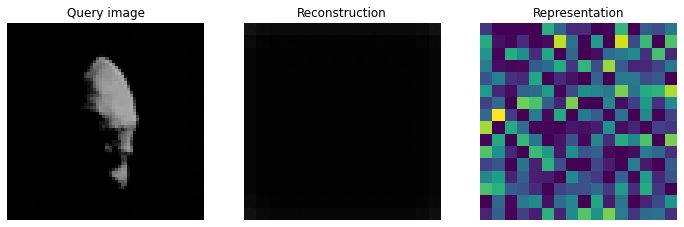

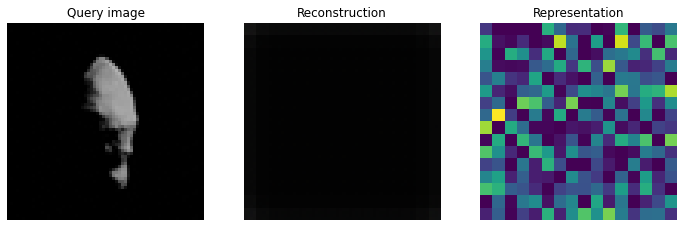

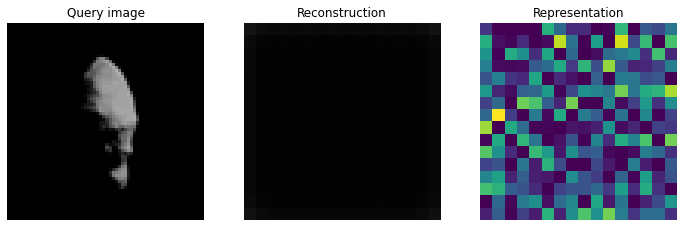

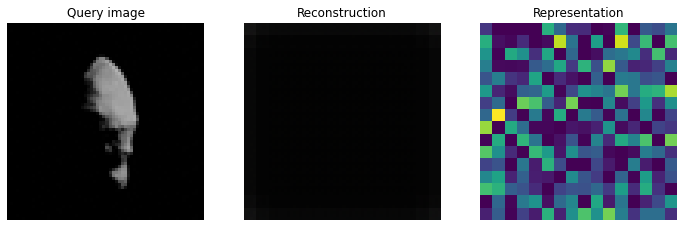

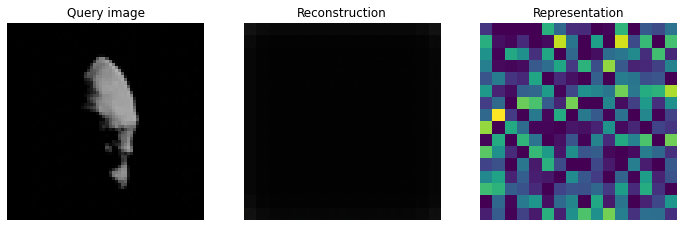

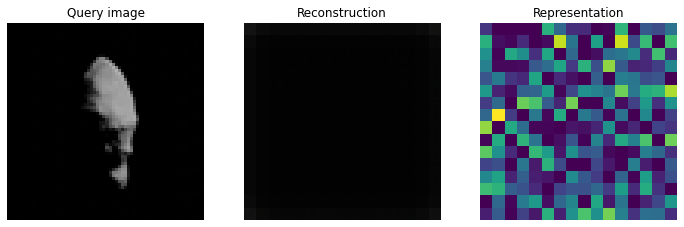

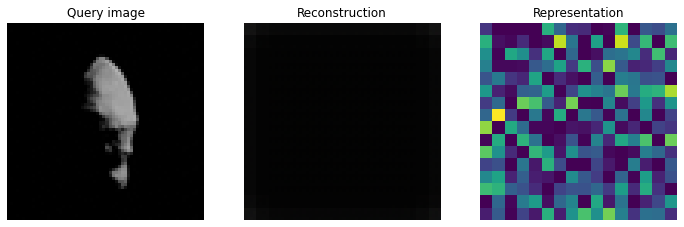

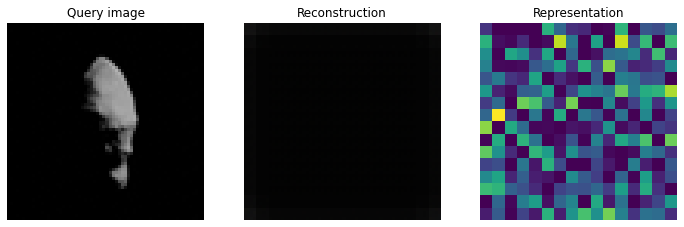

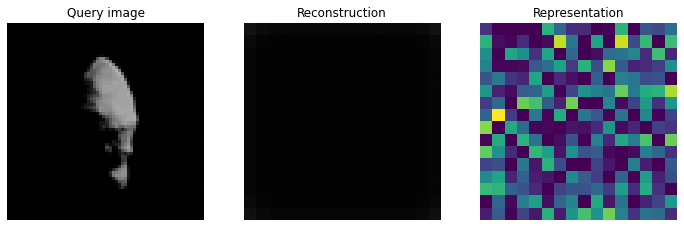

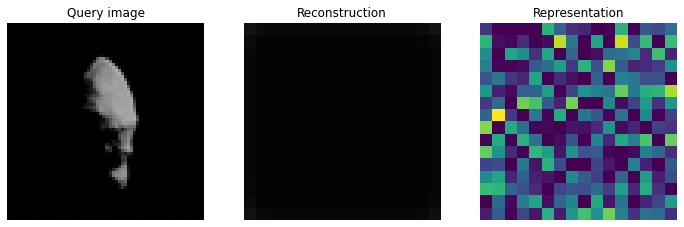

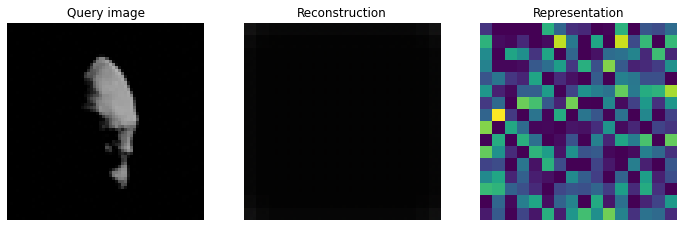

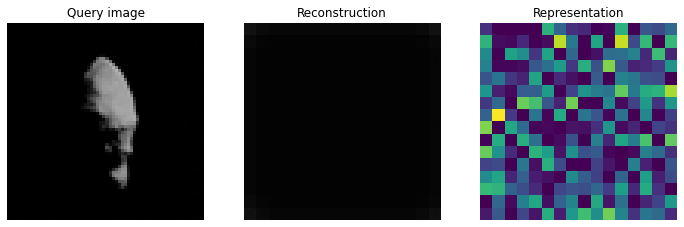

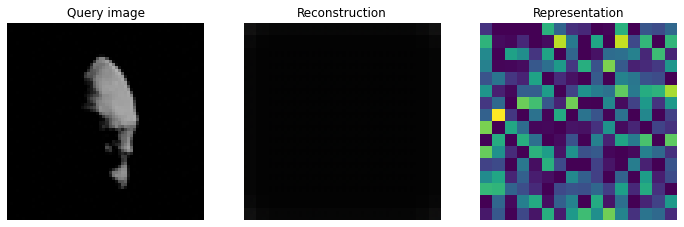

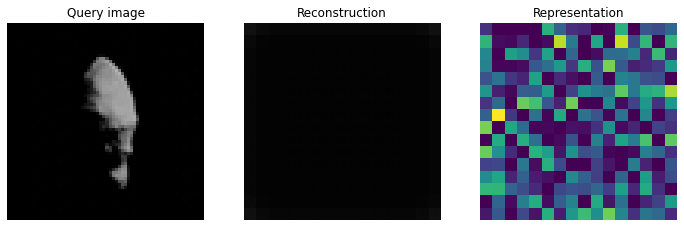

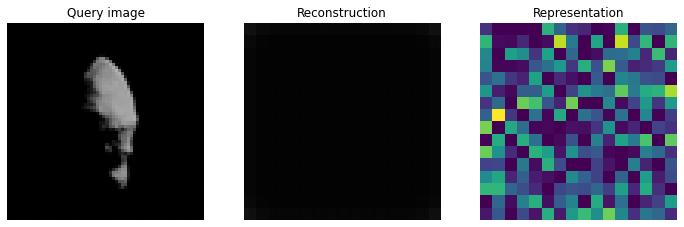

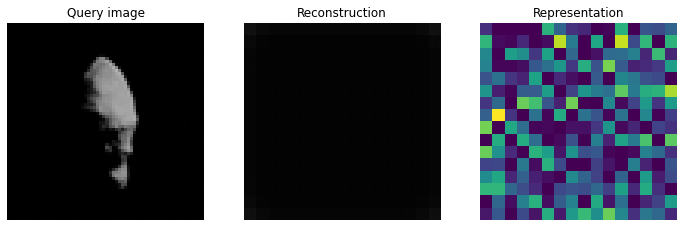

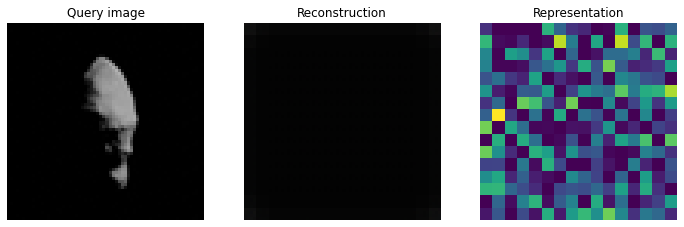

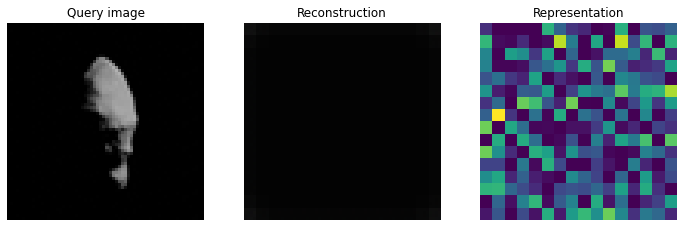

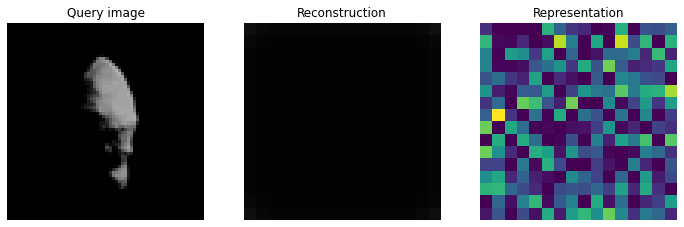

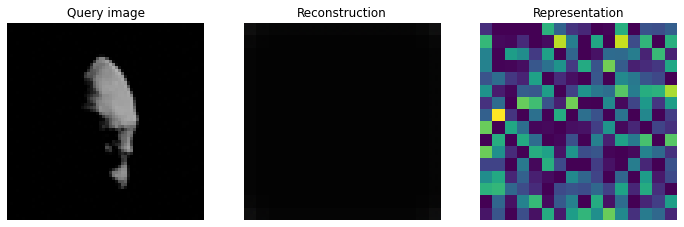

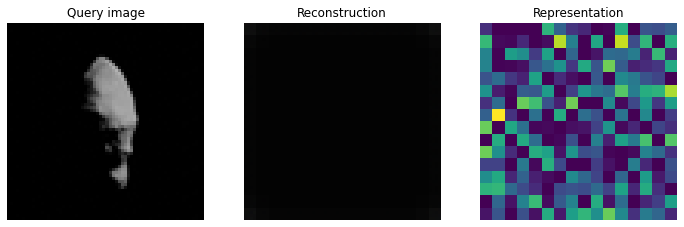

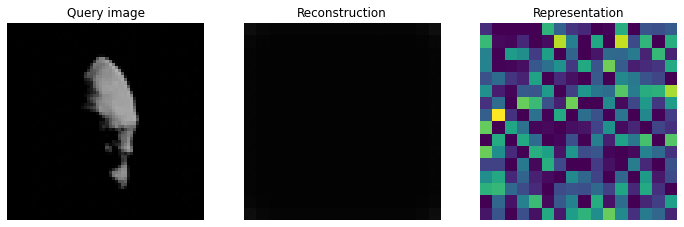

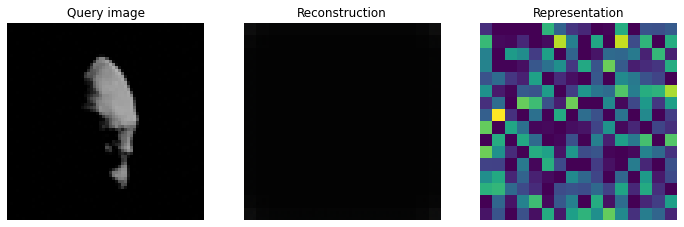

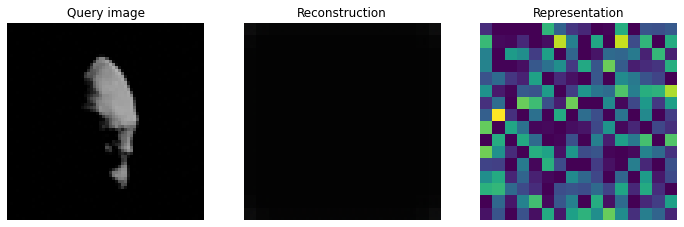

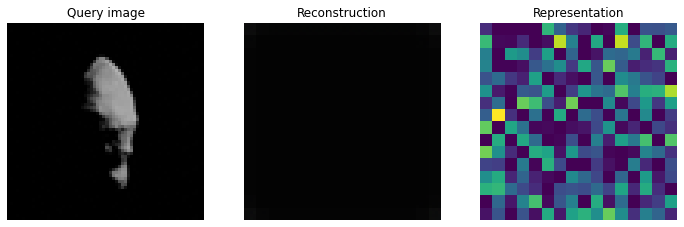

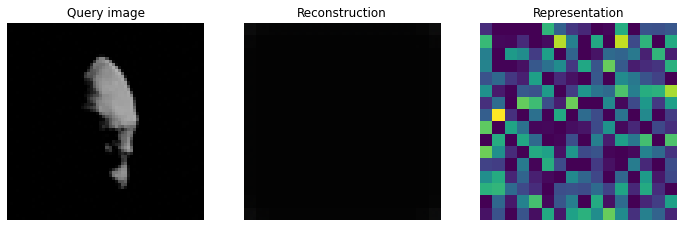

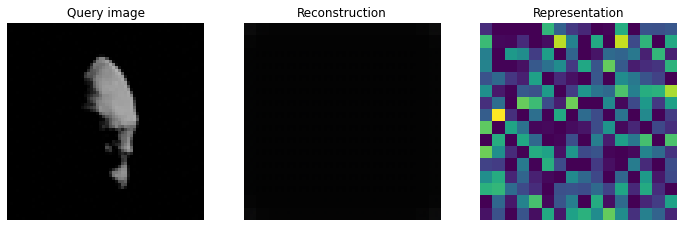

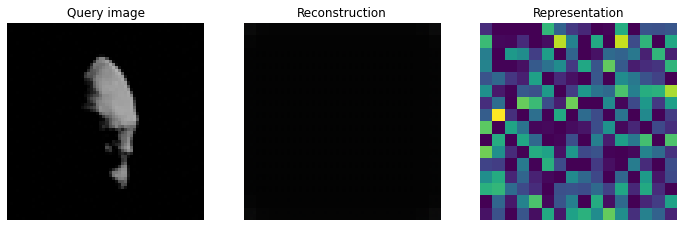

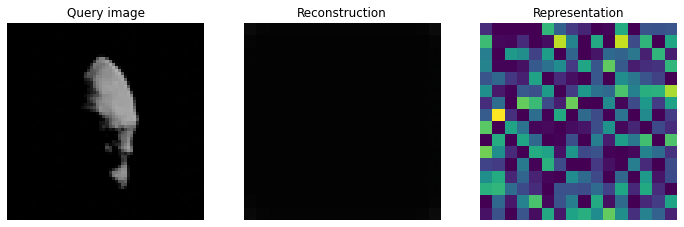

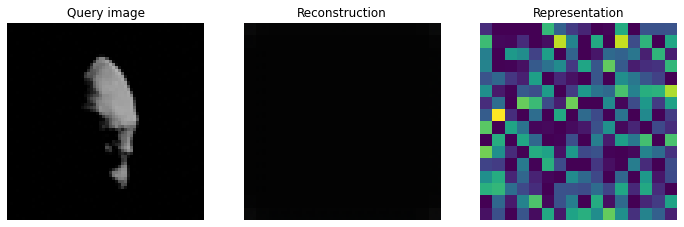

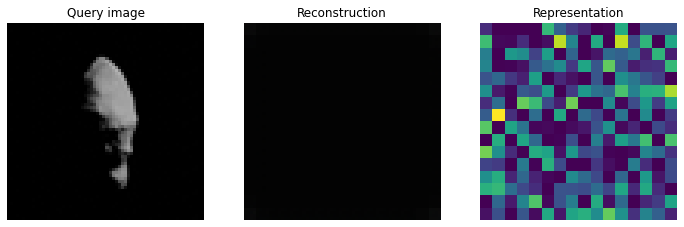

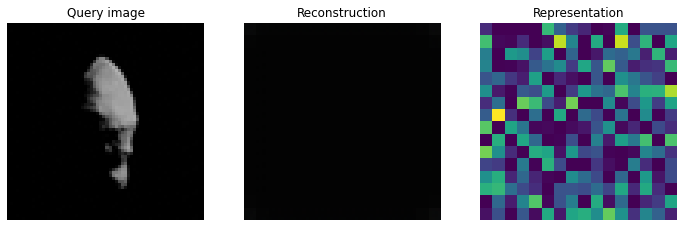

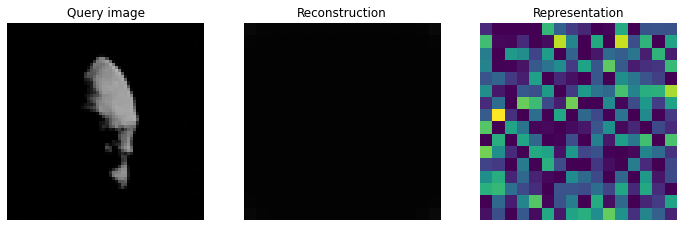

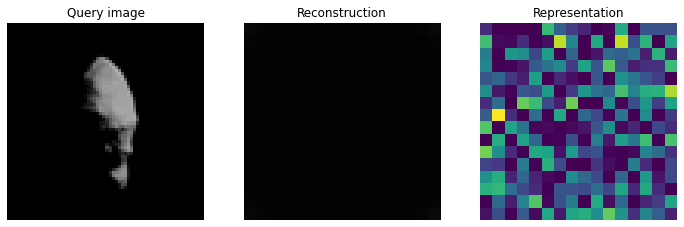

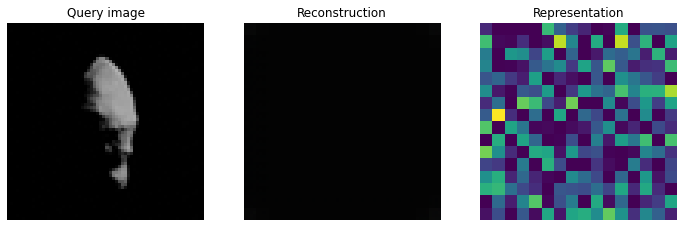

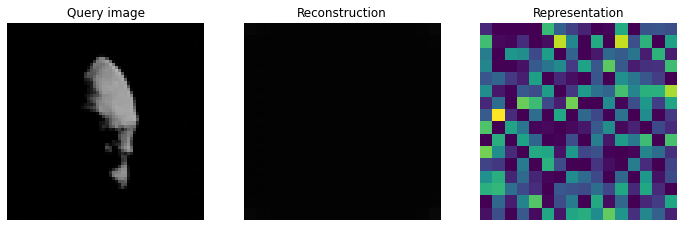

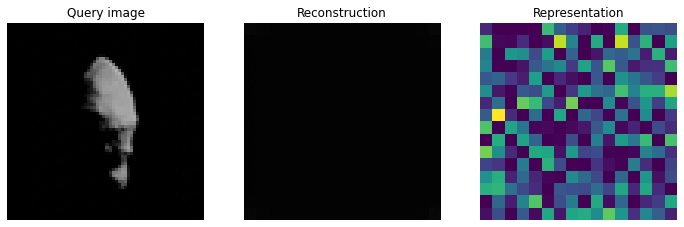

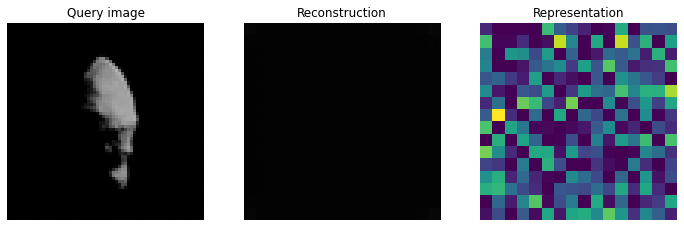

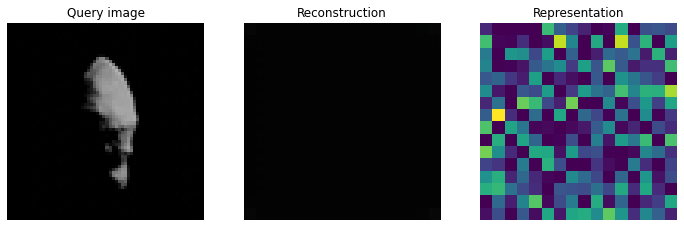

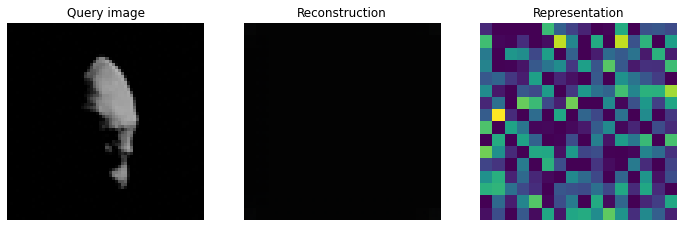

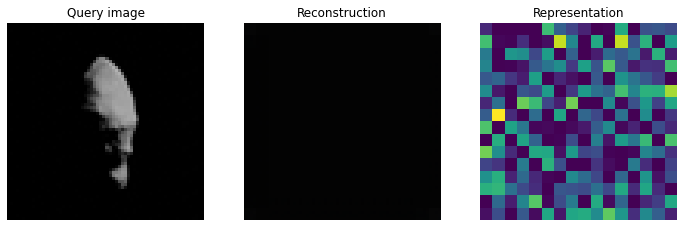

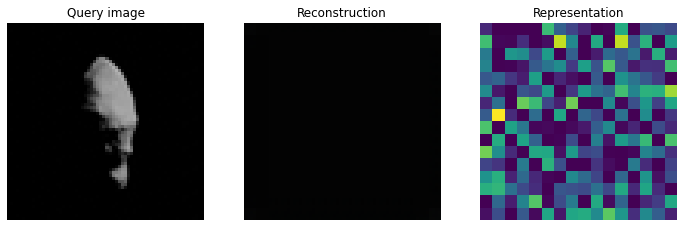

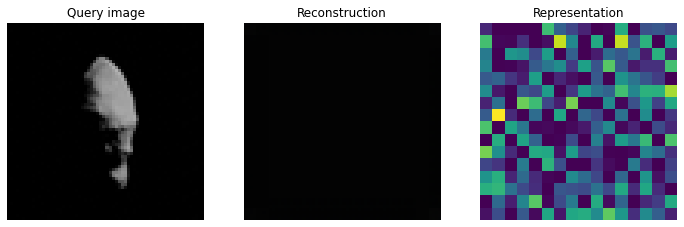

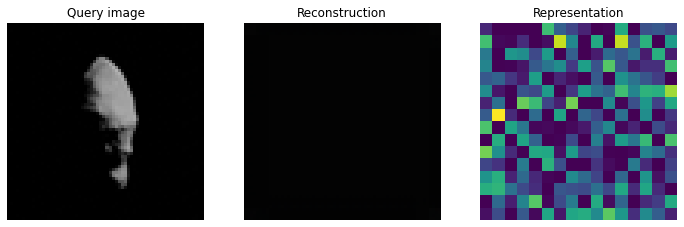

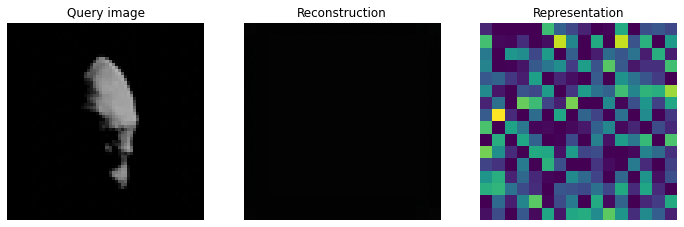

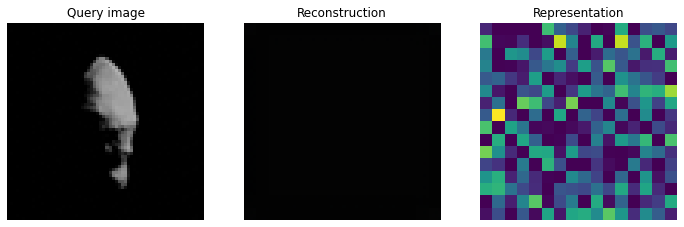

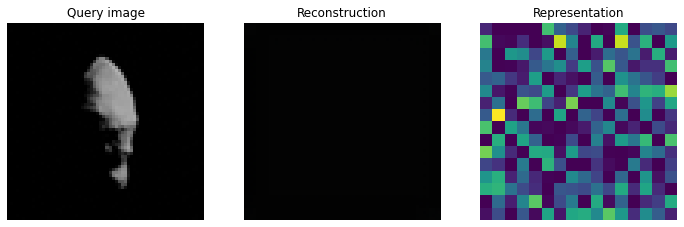

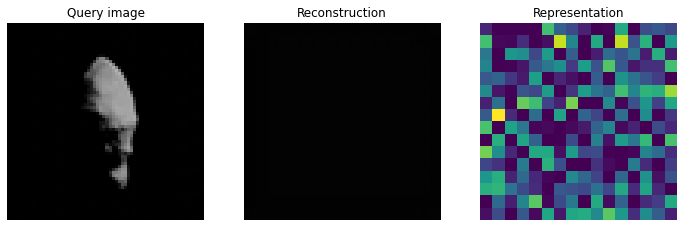

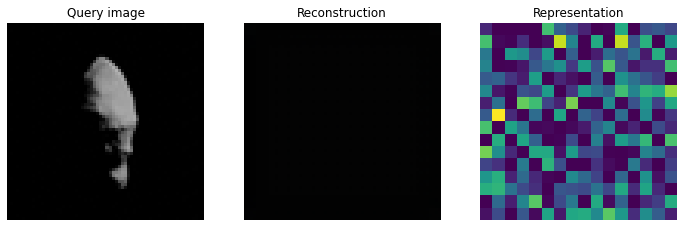

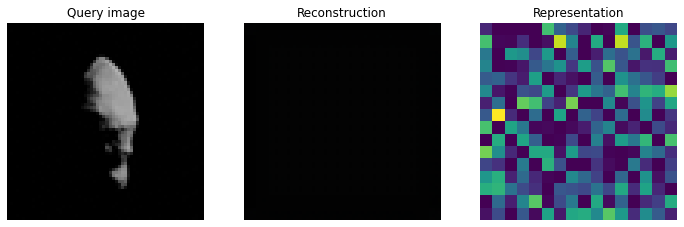

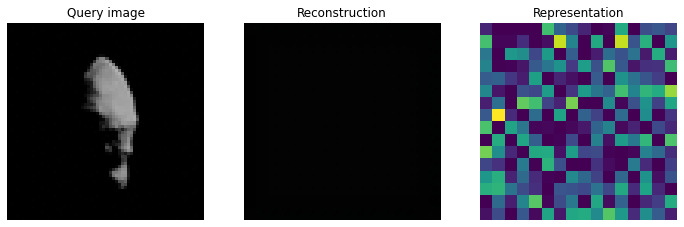

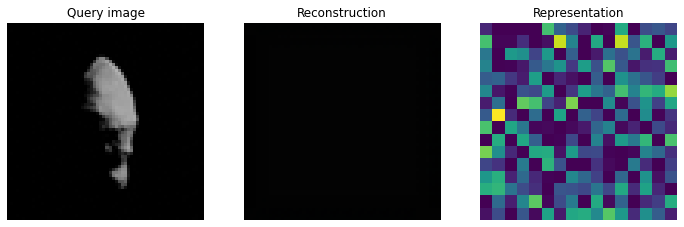

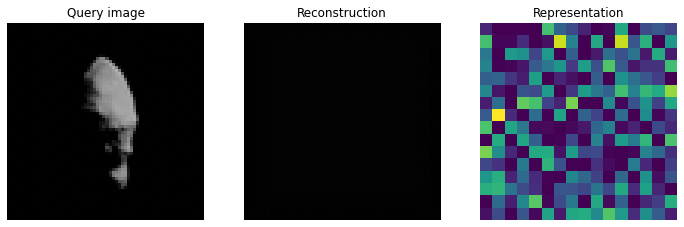

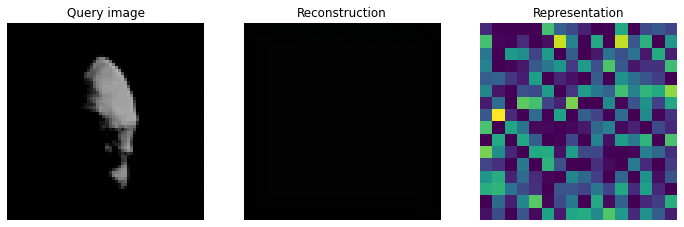

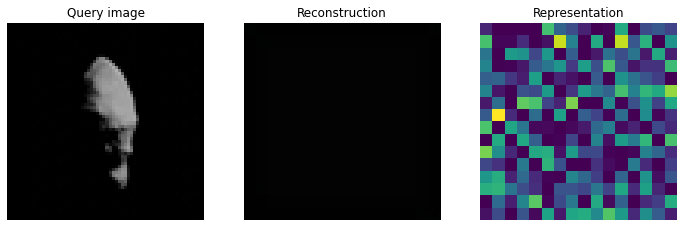

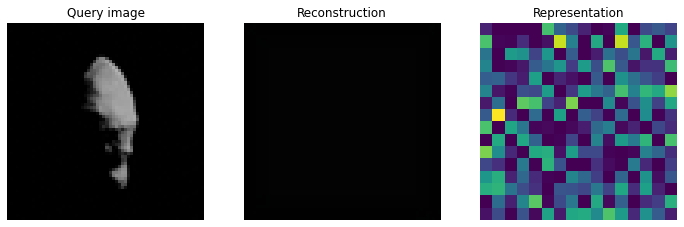

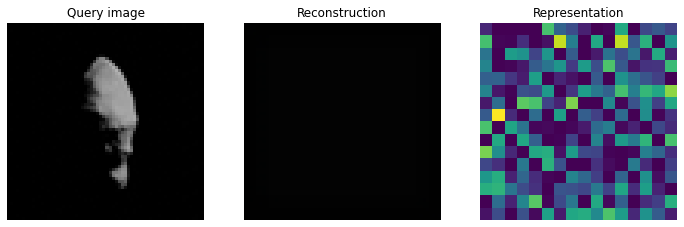

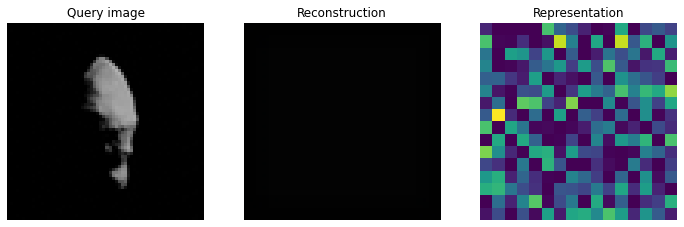

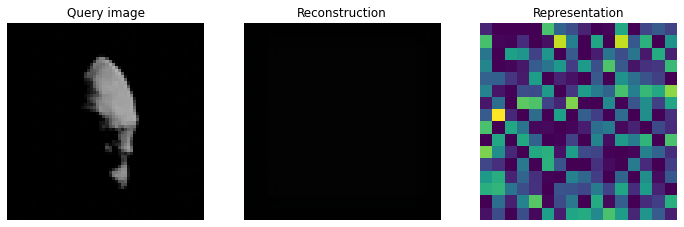

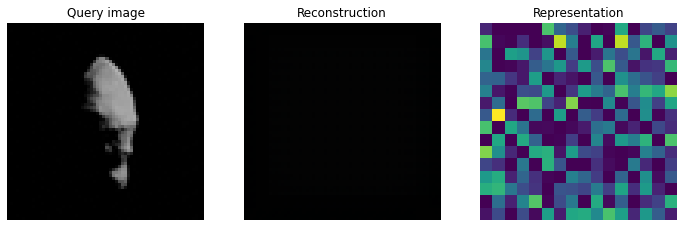

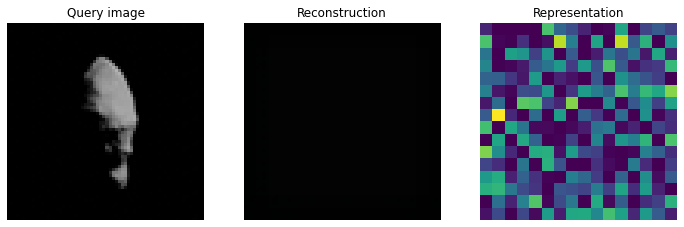

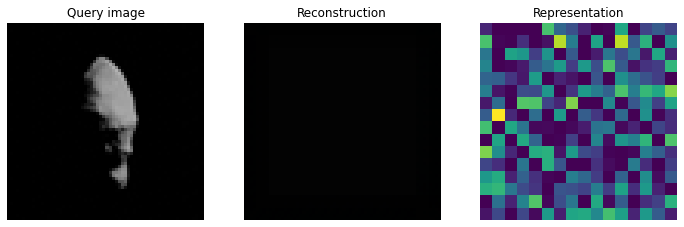

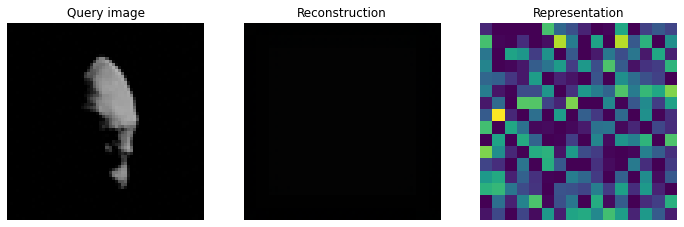

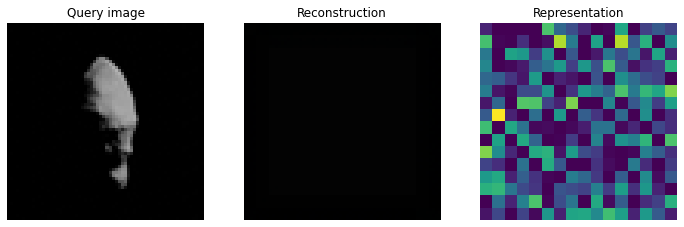

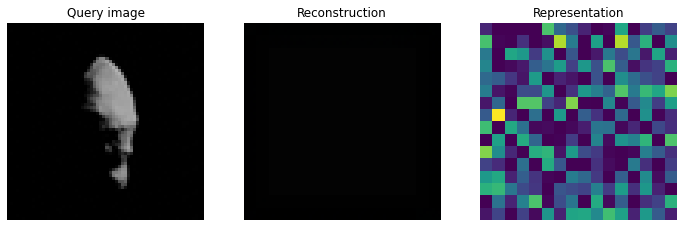

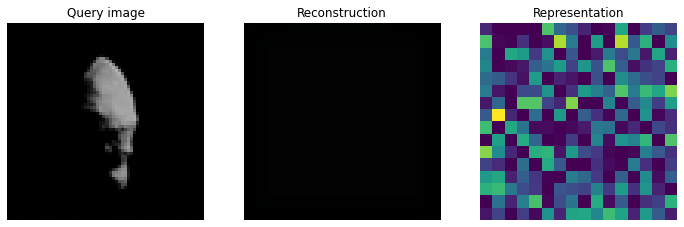

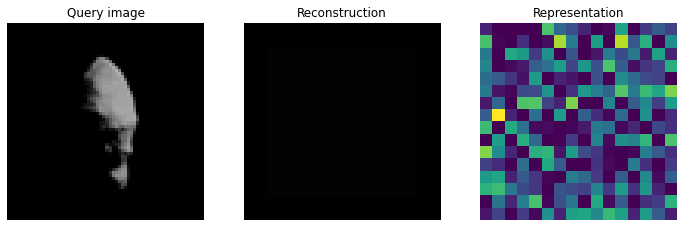

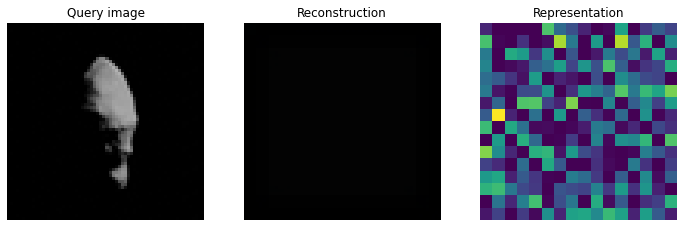

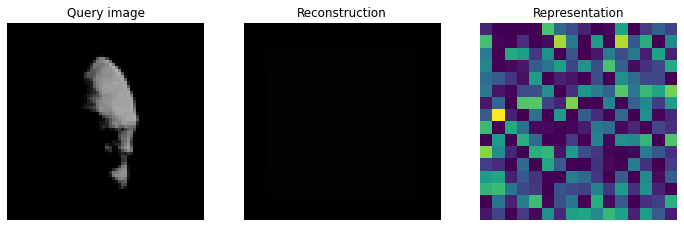

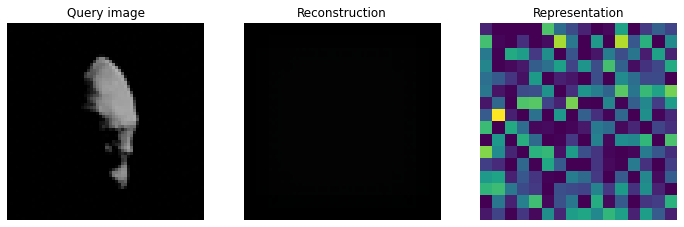

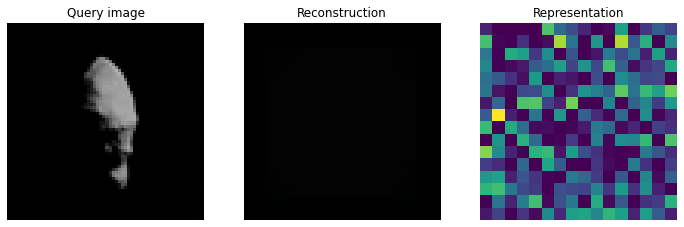

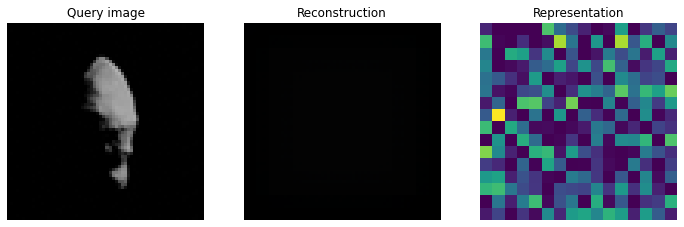

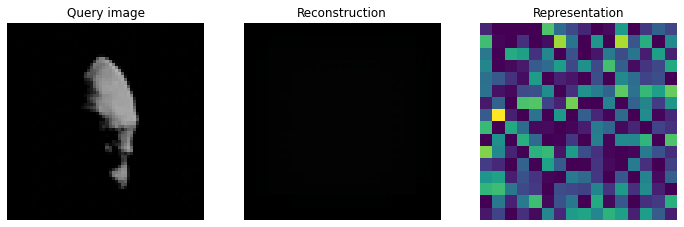

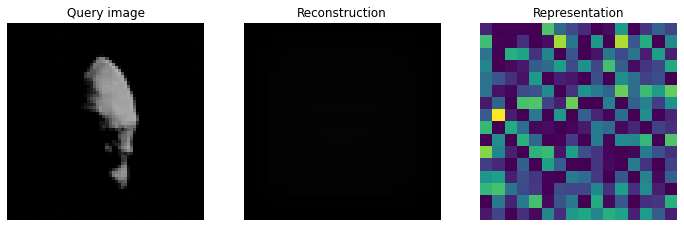

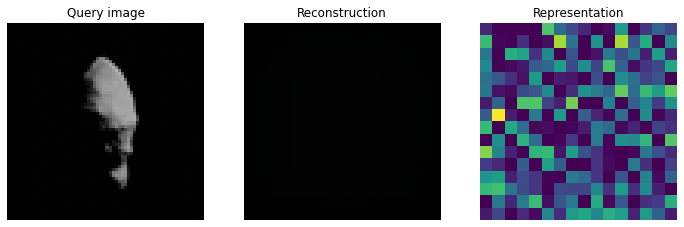

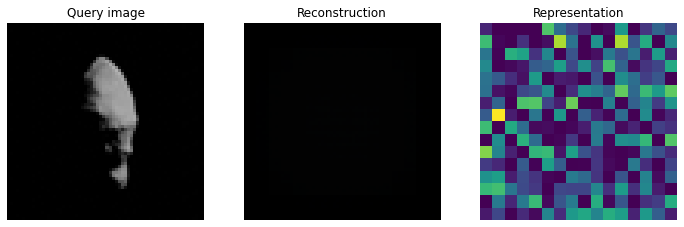

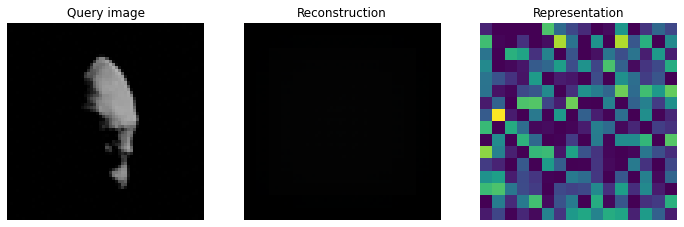

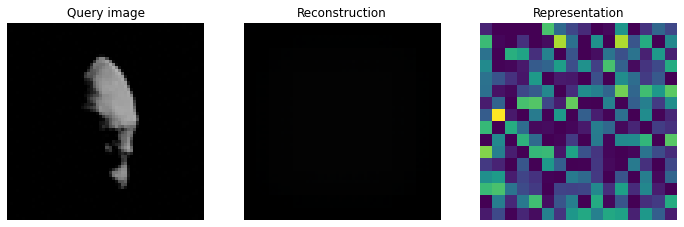

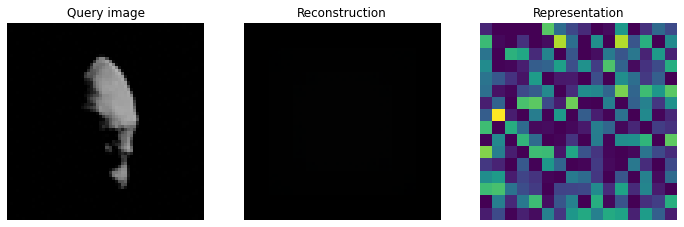

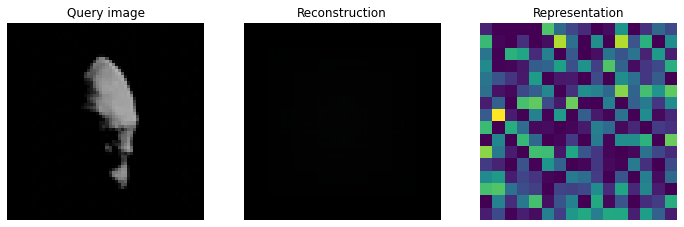

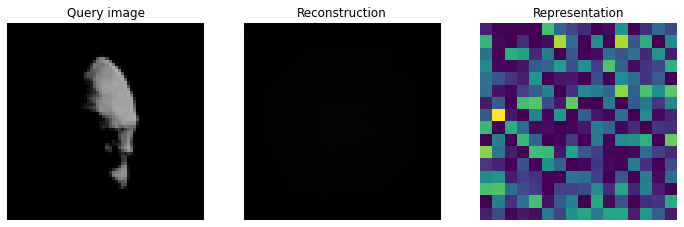

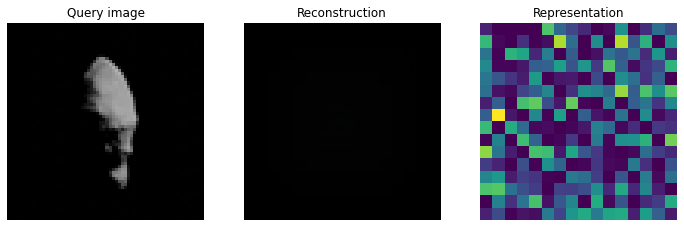

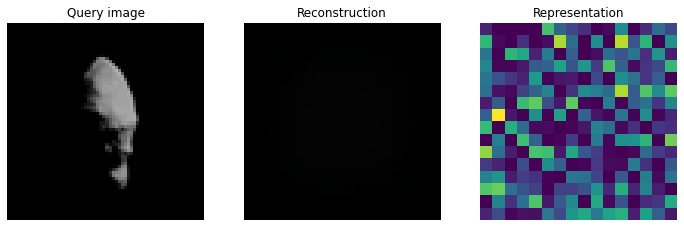

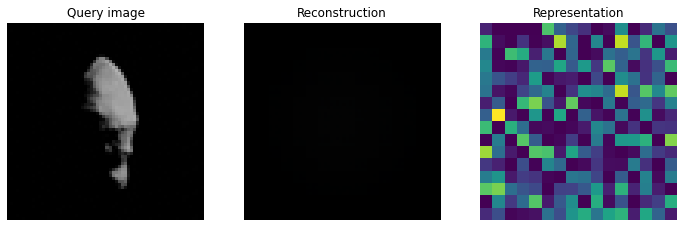

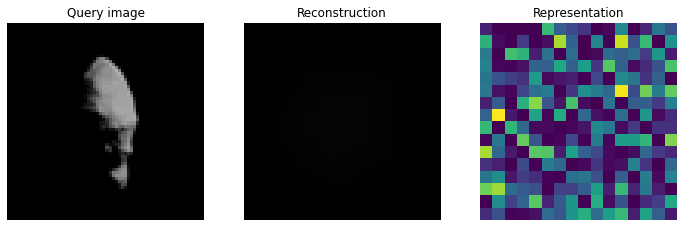

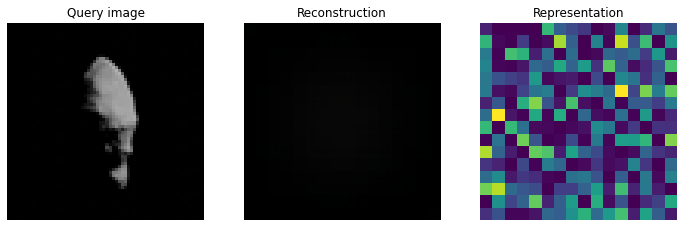

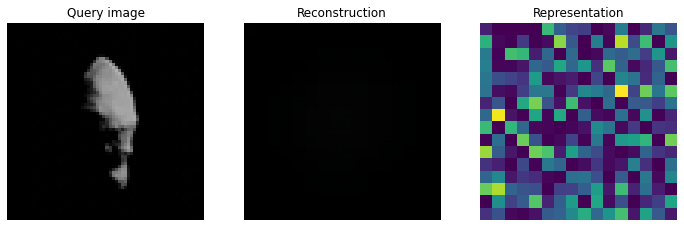

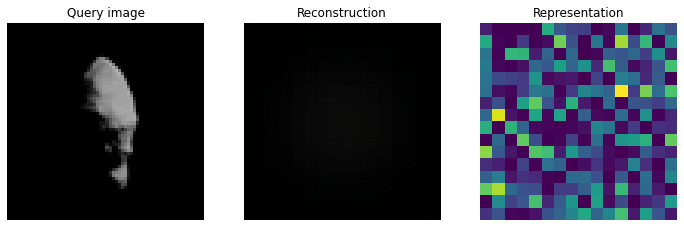

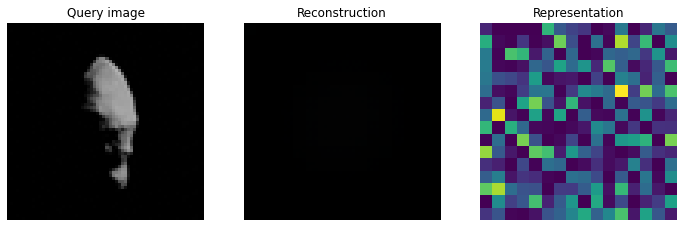

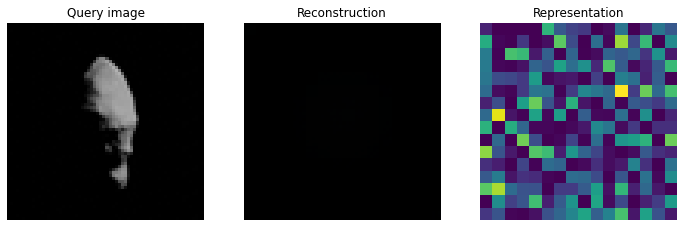

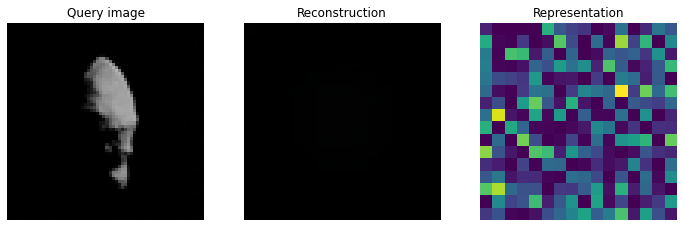

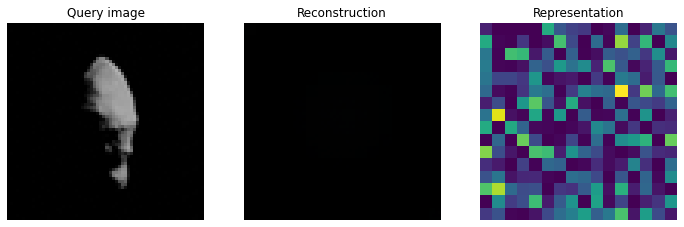

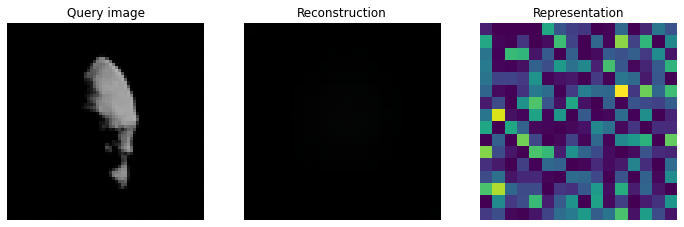

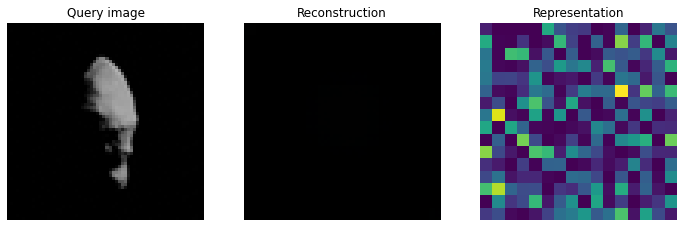

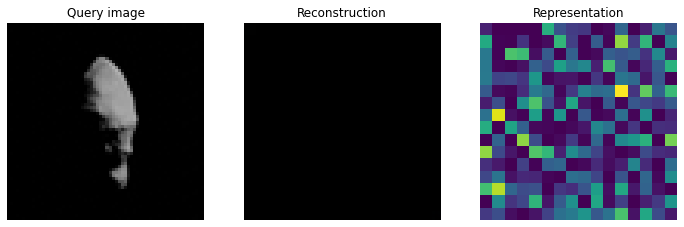

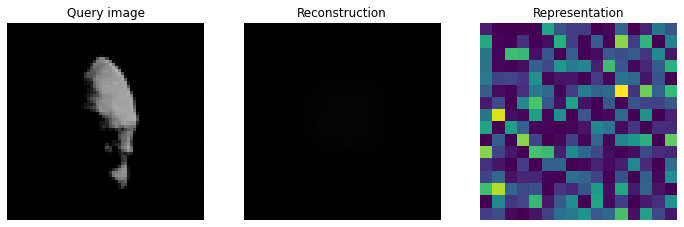

In [28]:
ims = []
batch_size, n_views, c, h, w = x_c.shape
for checkpoint in tqdm(checkpoint_dir):
    model = GenerativeQueryNetwork(x_dim=3, v_dim=7, r_dim=256, h_dim=128, z_dim=64, L=8)
    state_dict = torch.load('./pretrained/Circ_Orbit/' + checkpoint, map_location=torch.device('cpu'))
    state_dict = state_dict['model']
    new_state_dict = OrderedDict()
    for k, v in (state_dict.items()):
        name = k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))
    phi = model.representation(x_c[scene_id], v_c[scene_id])
    r = torch.sum(phi, dim=0)
    x_mu = model.generator.sample((h, w), v_q[scene_id].unsqueeze(0), r)

    ax1.imshow(x_q[scene_id].data.permute(1, 2, 0))
    ax1.set_title("Query image")
    ax1.axis("off")

    ax2.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax2.set_title("Reconstruction")
    ax2.axis("off")

    ax3.imshow(r.data.view(16, 16))
    ax3.set_title("Representation")
    ax3.axis("off")

    plt.savefig('./Circ_Orbit_Images/' + checkpoint[:-3] + '.png')